In [1]:
import yasa


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

In [3]:
data = np.loadtxt('/Users/ajsimon/Documents/Repositories/yasa-master/notebooks/data_N2_spindles_15sec_200Hz.txt')

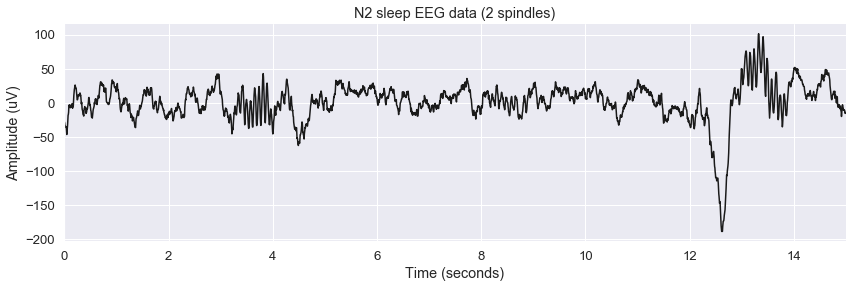

In [4]:
# Define sampling frequency and time vector
sf = 200.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N2 sleep EEG data (2 spindles)')
sns.despine()

In [5]:
# Apply the detection using yasa.spindles_detect
sp = yasa.spindles_detect(data, sf)

# Display the results using .summary()
sp.summary()

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,3.31,3.815,4.06,0.75,82.649913,19.408260,2.717369,0.497468,12.853460,10.0,0.668874,CHAN000,0
1,13.25,13.410,13.84,0.59,99.115345,24.528229,2.834379,0.238997,12.155747,7.0,0.268908,CHAN000,0


In [6]:
# Let's get a bool vector indicating for each sample
mask = sp.get_mask()
mask

array([0, 0, 0, ..., 0, 0, 0])

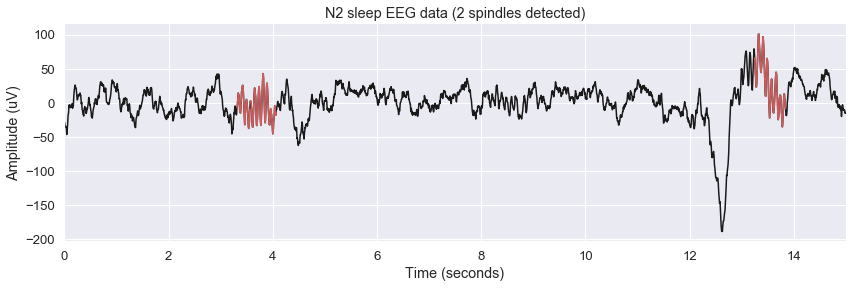

In [7]:
# Now let's plot
spindles_highlight = data * mask
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, data, 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N2 sleep EEG data (2 spindles detected)')
sns.despine()
# plt.savefig('detection.png', dpi=300, bbox_inches='tight')

In [8]:
# The default verbose is None which corresponds to verbose='warning'
sp = yasa.spindles_detect(data, sf, thresh={'rms': None}, verbose='info')
sp.summary()

25-Jun-20 09:26:00 | INFO | Number of samples in data = 3000
25-Jun-20 09:26:00 | INFO | Sampling frequency = 200.00 Hz
25-Jun-20 09:26:00 | INFO | Data duration = 15.00 seconds
25-Jun-20 09:26:00 | INFO | Trimmed standard deviation of CHAN000 = 15.5869 uV
25-Jun-20 09:26:00 | INFO | Peak-to-peak amplitude of CHAN000 = 289.6042 uV
25-Jun-20 09:26:00 | INFO | N supra-theshold relative power = 313
25-Jun-20 09:26:00 | INFO | N supra-theshold moving corr = 345


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,3.31,3.815,4.06,0.75,82.649913,19.408260,2.717369,0.497468,12.853460,10.0,0.668874,CHAN000,0
1,13.25,13.410,13.84,0.59,99.115345,24.528229,2.834379,0.238997,12.155747,7.0,0.268908,CHAN000,0


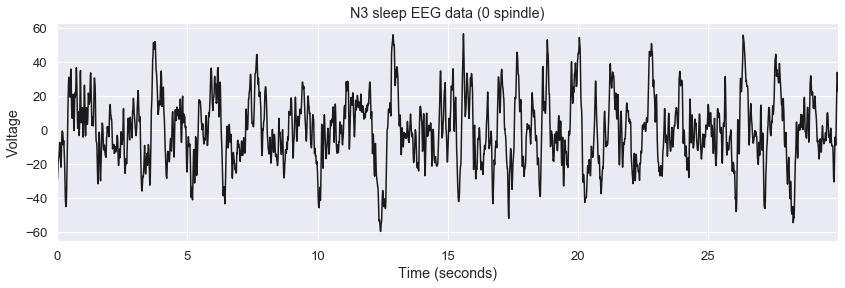

In [9]:
data_no_sp = np.loadtxt('/Users/ajsimon/Documents/Repositories/yasa-master/notebooks/data_N3_no-spindles_30sec_100Hz.txt')
sf_no_sp = 100
times_no_sp = np.arange(data_no_sp.size) / sf_no_sp

plt.figure(figsize=(14, 4))
plt.plot(times_no_sp, data_no_sp, 'k')
plt.xlim(0, times_no_sp.max())
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([times_no_sp.min(), times_no_sp.max()])
plt.title('N3 sleep EEG data (0 spindle)')
sns.despine()

In [10]:
sp = yasa.spindles_detect(data_no_sp, sf_no_sp)
sp

25-Jun-20 09:27:41 | WARNING | No spindle were found in channel CHAN000.
25-Jun-20 09:27:41 | WARNING | No spindles were found in data. Returning None.


In [11]:
from mne.filter import resample, filter_data

# Broadband (0.1 - 30 Hz) bandpass filter
freq_broad = (0.1, 30)
data_broad = filter_data(data, sf, freq_broad[0], freq_broad[1], method='fir',verbose=0)

<ipython-input-11-959c576f3cd7>:5: RuntimeWarning: filter_length (6601) is longer than the signal (3000), distortion is likely. Reduce filter length or filter a longer signal.
  data_broad = filter_data(data, sf, freq_broad[0], freq_broad[1], method='fir',verbose=0)


In [12]:
from mne.filter import resample, filter_data

# Broadband (1 - 30 Hz) bandpass filter
freq_broad = (1, 30)
data_broad = filter_data(data, sf, freq_broad[0], freq_broad[1], method='fir',verbose=0)

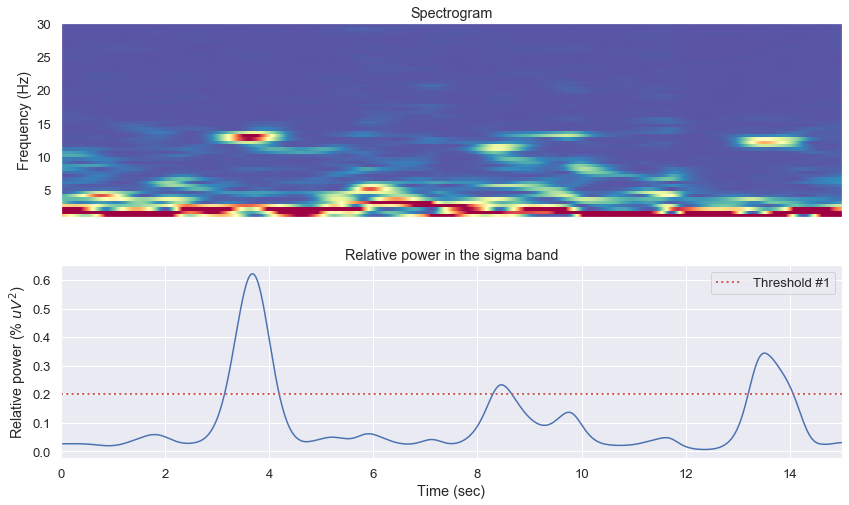

In [13]:
# Compute the pointwise relative power using STFT and cubic interpolation
f, t, Sxx = yasa.main.stft_power(data_broad, sf, window=2, step=.2, band=freq_broad, norm=True, interp=True)

# Extract the relative power in the sigma band
idx_sigma = np.logical_and(f >= 11, f <= 16)
rel_pow = Sxx[idx_sigma].sum(0)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
plt.subplots_adjust(hspace=.25)
im = ax1.pcolormesh(t, f, Sxx, cmap='Spectral_r', vmax=0.2)
ax1.set_title('Spectrogram')
ax1.set_ylabel('Frequency (Hz)')
ax2.plot(t, rel_pow)
ax2.set_ylabel('Relative power (% $uV^2$)')
ax2.set_xlim(t[0], t[-1])
ax2.set_xlabel('Time (sec)')
ax2.axhline(0.20, ls=':', lw=2, color='indianred', label='Threshold #1')
plt.legend()
_ = ax2.set_title('Relative power in the sigma band')

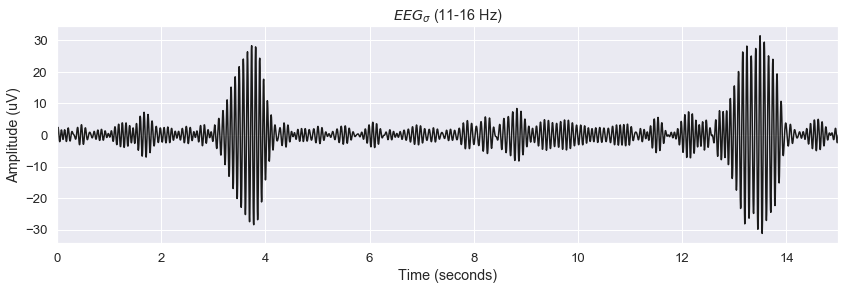

In [14]:
data_sigma = filter_data(data, sf, 12, 15, l_trans_bandwidth=1.5, 
                         h_trans_bandwidth=1.5, method='fir', verbose=0)

# Plot the filtered signal
plt.figure(figsize=(14, 4))
plt.plot(times, data_sigma, 'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.title('$EEG_{\sigma}$ (11-16 Hz)')
_ = plt.xlim(0, times[-1])

In [1]:
import pyedflib
import os

ModuleNotFoundError: No module named 'pyedflib'

In [2]:
import mne
file = '/Users/ajsimon/Dropbox (Personal)/Overnight PSG/01619_PSG_V1.edf'
data = mne.io.read_raw_edf(file)

Extracting EDF parameters from /Users/ajsimon/Dropbox (Personal)/Overnight PSG/01619_PSG_V1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names


In [4]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: E1-REF, E2-REF, E3-REF, E4-REF, E5-REF, E6-REF, M1-REF, M2-REF, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 200.0 Hz
 meas_date: 2016-03-01 21:33:49 UTC
 nchan: 32
 projs: []
 sfreq: 400.0 Hz
>

['E1-REF',
 'E2-REF',
 'E3-REF',
 'E4-REF',
 'E5-REF',
 'E6-REF',
 'M1-REF',
 'M2-REF',
 'F3-REF',
 'F4-REF',
 'C3-REF',
 'C4-REF',
 'O1-REF',
 'O2-REF',
 'EKG 1-REF',
 'EKG 2-REF',
 'CHIN L-REF',
 'CHIN R-REF',
 'CHIN A-REF',
 'PRESSURE-REF',
 'THERMAL-REF',
 'CHEST-REF',
 'ABDOMINAL-REF',
 'XXX-REF',
 'L LEG 1-REF',
 'L LEG 2-REF',
 'R LEG 1-REF',
 'R LEG 2-REF',
 'L ARM 1-REF',
 'L ARM 2-REF',
 'R ARM 1-REF',
 'R ARM 2-REF']

In [6]:
shape(raw_data)


NameError: name 'shape' is not defined

In [7]:
size(raw_data)


NameError: name 'size' is not defined

In [8]:
np.shape(raw_data)

NameError: name 'np' is not defined

In [9]:
import numpy as np

In [10]:
np.shape(raw_data)


(32, 15791200)

In [11]:
EEG_data = raw_data(8:13,:)

SyntaxError: invalid syntax (<ipython-input-11-f96ea6800764>, line 1)

In [12]:
EEG_data = raw_data([8:13,:])

SyntaxError: invalid syntax (<ipython-input-12-3661a46c1d51>, line 1)

In [13]:
EEG_data = raw_data[8:13,:]

In [14]:
np.shape(EEG_data)

(5, 15791200)

In [15]:
EEG_data[5,1:100]

IndexError: index 5 is out of bounds for axis 0 with size 5

In [16]:
EEG_data = raw_data[8:14,:]

In [17]:
chan = ['F3','F4','C3','C4','O1','O2']

In [18]:
sf = 400.

In [19]:
art, zscores = yasa.art_detect(data, sf, window=5, method='covar', threshold=3)
art.shape, zscores.shape

NameError: name 'yasa' is not defined

In [20]:
import yasa


In [21]:
art, zscores = yasa.art_detect(data, sf, window=5, method='covar', threshold=3)
art.shape, zscores.shape

((7895,), (7895,))

In [22]:
# Art is an aray of 0 and 1, where 0 indicates a clean (or good epoch)  and 1 indicates an artifact epoch
print(art)
print(f'{art.sum()} / {art.size} epochs rejected.')

[False False False ... False False False]
0 / 7895 epochs rejected.


In [23]:
# Plot the artifact vector
plt.plot(art);
plt.yticks([0, 1], labels=['Good (0)', 'Art (1)']);

NameError: name 'plt' is not defined

In [24]:
import matplotlib.pyplot as plt

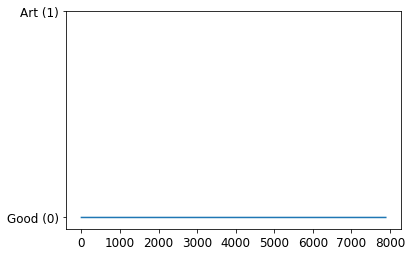

In [25]:
# Plot the artifact vector
plt.plot(art);
plt.yticks([0, 1], labels=['Good (0)', 'Art (1)']);

In [26]:
import matplotlib.pyplot as plt
sns.set(style='darkgrid', font_scale=1.2)

NameError: name 'sns' is not defined

In [27]:
yasa.plot_spectrogram(data[0, :], sf, hypno);

NameError: name 'hypno' is not defined

In [28]:
yasa.plot_spectrogram(data[0, :], sf);

AssertionError: Data must be a 1D NumPy array.

In [29]:
yasa.plot_spectrogram(EEG_data[0, :], sf, hypno);

NameError: name 'hypno' is not defined

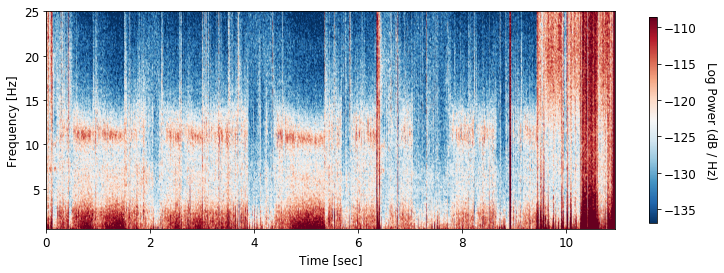

In [30]:
yasa.plot_spectrogram(EEG_data[0, :], sf);

In [31]:
np.shape(EEG.data)

NameError: name 'EEG' is not defined

In [32]:
np.shape(EEG_data)

(6, 15791200)

In [33]:
15791200/400

39478.0

In [34]:
39478.0/60

657.9666666666667

In [35]:
657.9666666666667/60

10.966111111111111

In [36]:
art, zscores = yasa.art_detect(EEG_data, sf, window=5, method='covar', threshold=3)
art.shape, zscores.shape

((7895,), (7895,))

[False False False ...  True  True False]
217 / 7895 epochs rejected.


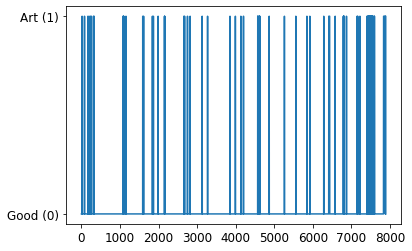

In [37]:
# Art is an aray of 0 and 1, where 0 indicates a clean (or good epoch)  and 1 indicates an artifact epoch
print(art)
print(f'{art.sum()} / {art.size} epochs rejected.')

# Plot the artifact vector
plt.plot(art);
plt.yticks([0, 1], labels=['Good (0)', 'Art (1)']);

In [38]:
sns.distplot(zscores)
plt.title('Histogram of z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Density')
plt.axvline(3, color='r', label='Threshold')
plt.axvline(-3, color='r')
plt.legend(frameon=False);

NameError: name 'sns' is not defined

In [39]:
import pandas as pd
import seaborn as sns

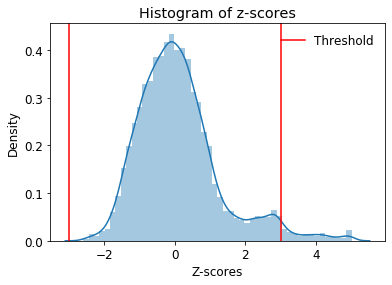

In [40]:
sns.distplot(zscores)
plt.title('Histogram of z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Density')
plt.axvline(3, color='r', label='Threshold')
plt.axvline(-3, color='r')
plt.legend(frameon=False);

In [41]:
from scipy.special import erf
threshold = 3
perc_expected_rejected = (1 - erf(threshold / np.sqrt(2))) * 100
print(f'{perc_expected_rejected:.2f}% of all epochs are expected to be rejected.')

0.27% of all epochs are expected to be rejected.


In [42]:
# Actual
(art.sum() / art.size) * 100
print(f'{(art.sum() / art.size) * 100:.2f}% of all epochs were actually rejected.')

2.75% of all epochs were actually rejected.


In [43]:
# The resolution of art is 5 seconds, so its sampling frequency is 1/5 (= 0.2 Hz)
sf_art = 1 / 5
art_up = yasa.hypno_upsample_to_data(art, sf_art, EEG_data, sf)
art_up.shape

26-Jun-20 12:34:00 | WARNING | Hypnogram is SHORTER than data by 3.00 seconds. Padding hypnogram with last value to match data.size.


(15791200,)

In [44]:
hypno.shape

NameError: name 'hypno' is not defined

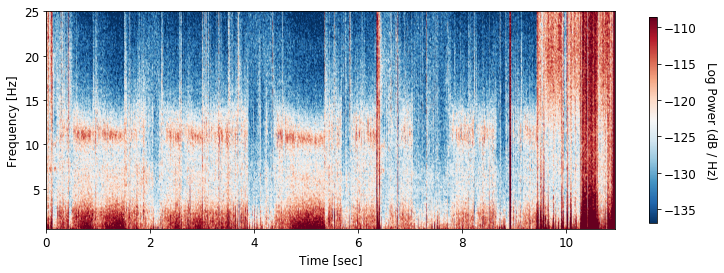

In [45]:
# Plot new hypnogram and spectrogram on Fz
yasa.plot_spectrogram(EEG_data[0, :], sf);

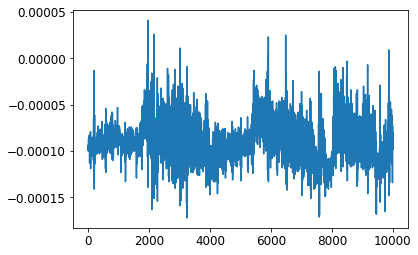

In [46]:
plt.plot(EEG_data[0,50000:60000])
plt.show()

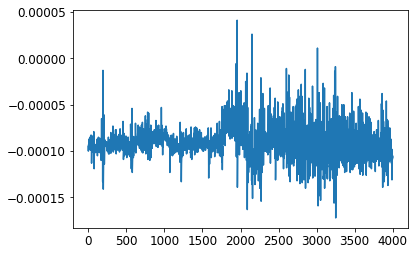

In [47]:
plt.plot(EEG_data[0,50000:54000])
plt.show()

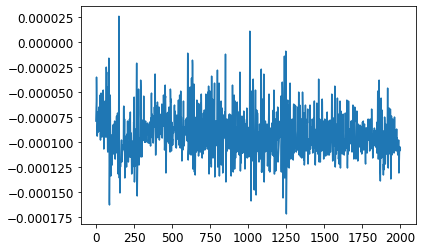

In [48]:
plt.plot(EEG_data[0,52000:54000])
plt.show()

In [49]:
raw_data.filter(0.1, 40)
raw_data.pick_channels(['F3-REF','F4-REF','C3-REF','C4-REF','O1-REF','O2-REF',])

AttributeError: 'numpy.ndarray' object has no attribute 'filter'

In [50]:
raw.filter(0.1, 40)
raw.pick_channels(['F3-REF','F4-REF','C3-REF','C4-REF','O1-REF','O2-REF',])

NameError: name 'raw' is not defined

In [51]:
import mne


In [52]:
raw.filter(0.1, 40)
raw.pick_channels(['F3-REF','F4-REF','C3-REF','C4-REF','O1-REF','O2-REF',])

NameError: name 'raw' is not defined

In [53]:
import mne
# Load the EDF file, excluding the EOGs and EKG channels
raw = mne.io.read_raw_edf('/Users/ajsimon/Dropbox (Personal)/Overnight PSG/07403_PSG_V1.edf', preload=True, exclude=['EOG1', 'EOG2', 'EKG'])
raw.resample(100)                      # Downsample the data to 100 Hz
raw.filter(0.1, 40)                    # Apply a bandpass filter from 0.1 to 40 Hz
raw.pick_channels(['C4-A1', 'C3-A2'])  # Select a subset of EEG channels

Extracting EDF parameters from /Users/ajsimon/Dropbox (Personal)/Overnight PSG/07403_PSG_V1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15995199  =      0.000 ... 39987.997 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (33.010 sec)



ValueError: No channels match the selection.

In [54]:
raw.pick_channels(['F3-REF','F4-REF','C3-REF','C4-REF','O1-REF','O2-REF'])  # Select a subset of EEG channels

IndexError: index 8 is out of bounds for axis 0 with size 0

In [55]:
import mne
# Load the EDF file, excluding the EOGs and EKG channels
raw = mne.io.read_raw_edf('/Users/ajsimon/Dropbox (Personal)/Overnight PSG/07403_PSG_V1.edf', preload=True, exclude=['EOG1', 'EOG2', 'EKG'])
raw.resample(100)                      # Downsample the data to 100 Hz
raw.filter(0.1, 40)  
raw.pick_channels(['F3-REF','F4-REF','C3-REF','C4-REF','O1-REF','O2-REF'])  # Select a subset of EEG channels

Extracting EDF parameters from /Users/ajsimon/Dropbox (Personal)/Overnight PSG/07403_PSG_V1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15995199  =      0.000 ... 39987.997 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (33.010 sec)



<RawEDF | 07403_PSG_V1.edf, 6 x 3998800 (39988.0 s), ~183.1 MB, data loaded>

In [56]:
np.shape(raw)

ValueError: All picks must be < n_channels (6), got 6

In [57]:
eeg = raw.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

In [58]:
channels

['E1-REF',
 'E2-REF',
 'E3-REF',
 'E4-REF',
 'E5-REF',
 'E6-REF',
 'M1-REF',
 'M2-REF',
 'F3-REF',
 'F4-REF',
 'C3-REF',
 'C4-REF',
 'O1-REF',
 'O2-REF',
 'EKG 1-REF',
 'EKG 2-REF',
 'CHIN L-REF',
 'CHIN R-REF',
 'CHIN A-REF',
 'PRESSURE-REF',
 'THERMAL-REF',
 'CHEST-REF',
 'ABDOMINAL-REF',
 'XXX-REF',
 'L LEG 1-REF',
 'L LEG 2-REF',
 'R LEG 1-REF',
 'R LEG 2-REF',
 'L ARM 1-REF',
 'L ARM 2-REF',
 'R ARM 1-REF',
 'R ARM 2-REF']

In [59]:
np.shape(eeg)

(6, 3998800)

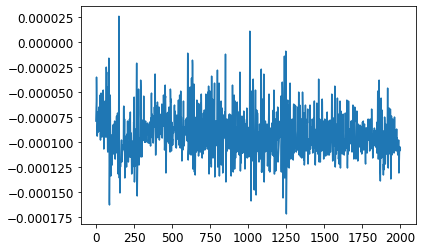

In [60]:
plt.plot(EEG_data[0,52000:54000])
plt.show()

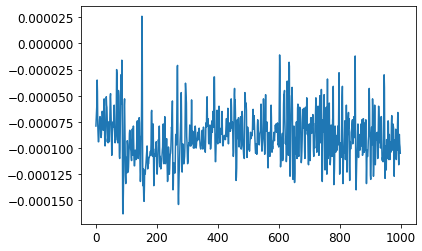

In [61]:
plt.plot(EEG_data[0,52000:53000])
plt.show()

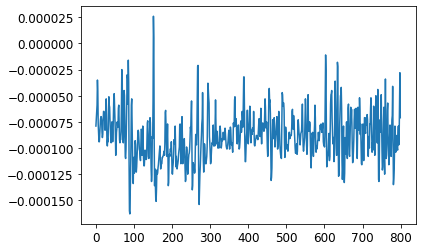

In [62]:
plt.plot(EEG_data[0,52000:52800])
plt.show()

In [63]:
info

#plt.figure(figsize=(14, 4))
#plt.plot(times, data_sigma, 'k')
#plt.xlabel('Time (seconds)')
#plt.ylabel('Amplitude (uV)')

<Info | 7 non-empty values
 bads: []
 ch_names: E1-REF, E2-REF, E3-REF, E4-REF, E5-REF, E6-REF, M1-REF, M2-REF, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 200.0 Hz
 meas_date: 2016-03-01 21:33:49 UTC
 nchan: 32
 projs: []
 sfreq: 400.0 Hz
>